
<a id='chap-tpdbscan'></a>

# Practical Work - DBSCAN

Useful external references :

- [Documentation NumPy](https://docs.scipy.org/doc/numpy/user/index.html)  
- [Documentation SciPy](https://docs.scipy.org/doc/scipy/reference/)  
- [Documentation MatPlotLib](http://matplotlib.org/)  
- [Site scikit-learn](http://scikit-learn.org/stable/index.html)  
- [Site langage python](https://www.python.org)  

The goal of this practical session is to illustrate the implementation of clustering with DBSCAN. First, we will observe the behavior of the algorithm in a synthetic case that defeats $k$-means. We will see how to use classical heuristics to determine the parameters of the algorithm and how to interpret the resulting partitioning. Finally, we will apply DBSCAN to a real dataset and illustrate
its use for detecting outliers.

*Source*: Cnam

## Density-based clustering in Scikit-Learn

In this session, we focus on  Density-Based Spatial Clustering of Applications with Noise (**DBSCAN**).

Like $k$-means, DBSCAN allows us to assign each observation of the data (`matrix n_samples x n_features`) with a cluster. However, DBSCAN is a transductive method: the algorithm cannot produce classifications for new data (the model must be retrained to include the new observations).

The description of the DBSCAN implementation can be found in
[https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

## DBSCAN clustering with generated data

Let's start by generating a synthetic dataset that consists of 500 observations in a 2D space. We will use a function built into Scikit-Learn that allows us to produce circular scatter plots:
[make_circles](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html).

(500, 2)


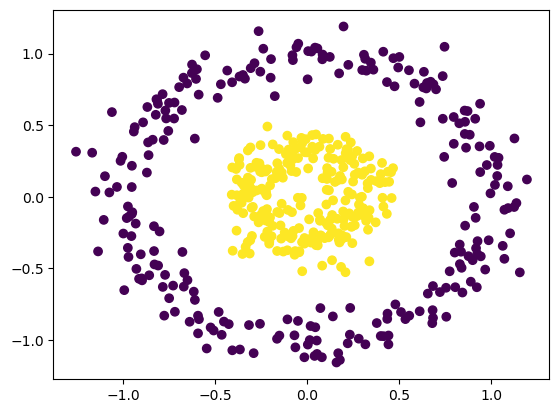

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from sklearn.utils import shuffle

# Generate a point cloud composed of two circles
# The cloud contains 500 observations (`n_samples`) with added Gaussian noise
# of standard deviation 0.1 (`noise`).
# The ratio between the radius of the small circle and the large circle
# is 0.3 (`factor`).
data, labels = sklearn.datasets.make_circles(n_samples=500, noise=0.1, factor=0.3, random_state=0)

print(data.shape)
# Random permutation of the rows of the matrix (shuffle the observations)
# data, labels = shuffle(data, labels)

# Display the point cloud
fig = plt.figure()
plt.scatter(data[:,0], data[:,1], c=labels)
plt.show()

## Question

How many groups does this dataset contain?   
***2 groups***

## Question

Perform partitioning of this dataset using $k$-means. What can we expect? What do you observe?  
***using kmeans, the model does not observe the circular structure of the data but partitions the data using a straight line.*** 

c:\Users\Ethel Ogallo\.conda\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


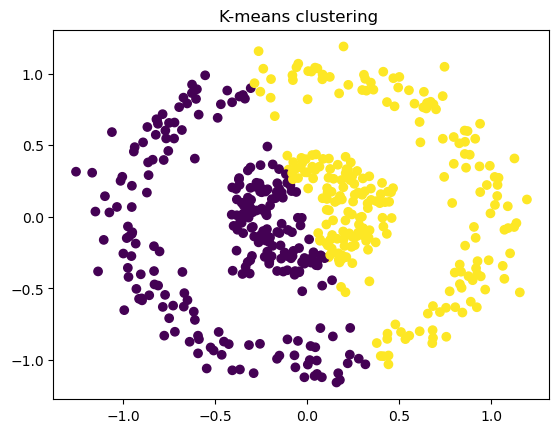

In [2]:
# kmeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)
labels_kmeans = kmeans.fit_predict(data)

plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=labels_kmeans)
plt.title("K-means clustering ")
plt.show()

Since the two circles are separated by an area without data, a density-based method seems appropriate. We can create a clustering model using DBSCAN by importing it from Scikit-Learn:

In [3]:
from sklearn.cluster import DBSCAN

db = DBSCAN() 

The arguments of the DBSCAN constructor are as follows:

- `eps`: the neighborhood dimension, i.e., the maximum distance   between two observations that allows them to be considered neighbors   of each other,
- `min_samples`: the minimum number of neighbors that a central point must have,  
- `metric`: the distance to be considered (by default, the Euclidean distance is used).  


The following methods can be called:
- `.fit(X)`: performs automatic fitting using the DBSCAN method on the observation matrix `X`. The results are stored in the `.labels_` attribute.
- `.fit_predict(X)`: identical to `.fit(X)` but returns the cluster labels directly.  


The following attributes are available after calling the `.fit()` method:
- `core_sample_indices_`: the indices of the central points.  
- `labels_`: the group numbers of the points in the observation matrix.  

## Question

What are the default values for the important parameters of DBSCAN in scikit-learn ($\varepsilon$ and $minPts$)?

***eps, default=0.5 and  min_samples default=5***


Let us apply clustering using DBSCAN to our dataset. As with $k$-means, this step can be performed in two stages by calling `fit()` and then accessing the `labels_` attribute, or it can be done in a single operation using the `fit_predict()` method:

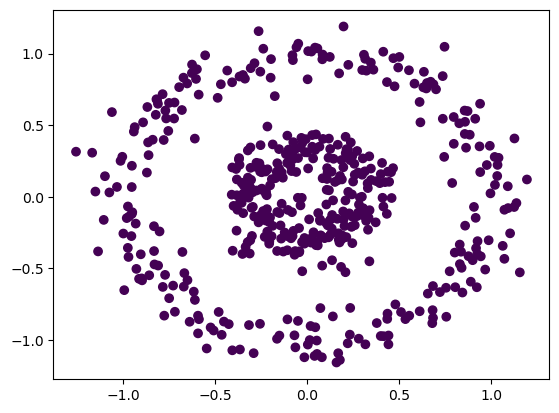

In [4]:
predictions = db.fit_predict(data)
# equivalent to
# db.fit(data)
# predictions = db.labels_

# Display the point cloud coloured by predictions
fig = plt.figure()
plt.scatter(data[:,0], data[:,1], c=predictions)
plt.show()

## Question

What do you observe ? Which parameter is likely to need adjusting to improve this result?  
***we get 1 group. Adjust eps to improve the result as this impacts the distance between observations***

To refine our analysis, we will apply Schubert's heuristic, which uses the graph of $k$-distances in the observation cloud.
For now, we will assume that `min_samples` is set to its default value, i.e., 5. We must therefore plot the graph of 4-distances for our observation matrix.

In [5]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=4).fit(data)
distances, _ = nn.kneighbors(data)

## Question

Using the [NearestNeighbors documentation in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors), explain what the code above does.   

***The code finds the 4 nearest neighbors (k = 4) for each observation in the dataset and returns both the indices and distances of these neighbors.***

We can now plot the 4-distance graph. To do this, we only keep the distance of each point to its fourth neighbor, then sort this list in descending order.

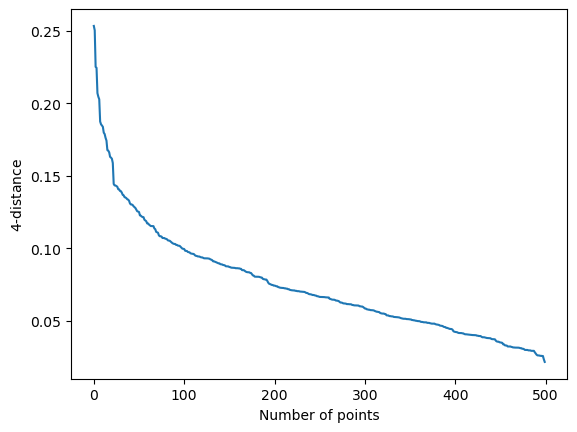

In [6]:
distances_triees = np.sort(distances[:,-1])[::-1]
fig = plt.figure()
plt.plot(distances_triees)
plt.xlabel("Number of points")
plt.ylabel("$4$-distance")
plt.show()

## Question

From the 4-distance graph, determine the appropriate value of `eps` for this dataset using the heuristic seen in the course. Apply DBSCAN again with these parameters. Display the resulting point cloud.

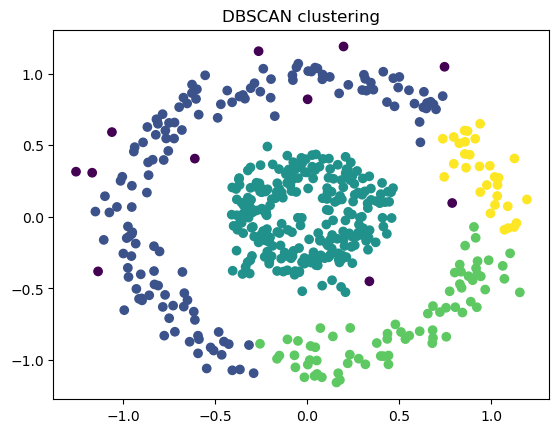

In [7]:
# using eps 0.15  which is the value at the elbow of the graph
db = DBSCAN(eps=0.15)
predictions = db.fit_predict(data)

# Display the point cloud coloured by predictions
fig = plt.figure()
plt.scatter(data[:,0], data[:,1], c=predictions)
plt.title("DBSCAN clustering")
plt.show()


## Question

How many groups do you get? What do the label observations `-1` correspond to?  
***4 groups observed. The -1 corresponds to noise predicted by the model***

## Classification with DBSCAN on the Iris dataset

The Iris dataset is a classic in statistical learning. It contains 150 observations of plants according to four attributes:
- length of the [sepal](https://fr.wikipedia.org/wiki/S%C3%A9pale),
- width of the sepal,  
- petal length,  
- petal width.  

The observations belong to one of three classes, corresponding to the three species of iris: *Setosa*, *Versicolour*, or *Virginica*.

More details can be found in the [documentation](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

Iris is integrated into scikit-learn and is available from the submodule `sklearn.datasets`:

In [8]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)
print(X.shape)

(150, 4)


## Question

How many observations does this dataset contain? *150 observations*

In order to simulate the presence of outliers, we will randomly generate 20 noisy points, drawn according to a uniform distribution between the minimum and maximum values of each column of the observation matrix:

In [9]:
min_, max_ = X.min(axis=0), X.max(axis=0)
noise = np.random.rand(20, 4) * (max_ - min_) + min_
X = np.concatenate((X, noise))
y = np.concatenate((y, -1 * np.ones(20, dtype=int)))

## Question

Perform a principal component analysis and visualize the Iris dataset projected along its first two principal axes.

(170, 2)


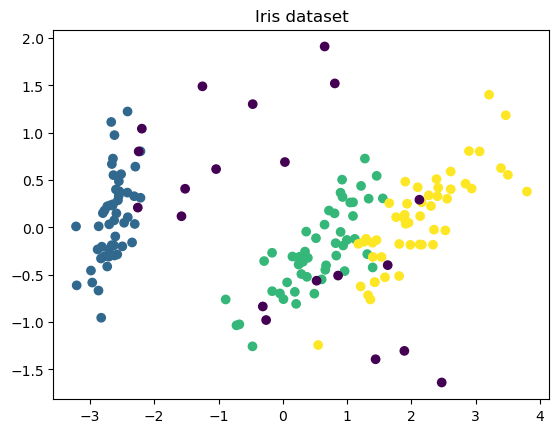

In [10]:
# pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data = pca.fit_transform(X)
print(data.shape)

#visualize
fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=y)
plt.title("Iris dataset")
plt.show()


## Question

Apply clustering using DBSCAN (work on the 4-dimensional data, not the projected data!). Visualize the groups obtained in the main plane of the ACP (2 first components). Compare this result with the partitioning obtained using $k$-means.

The points corresponding to label -1 are those identified as outliers. If the value of $ \varepsilon $ has been chosen correctly, the noisy observations injected into the dataset should have been isolated by DBSCAN.

Predicted outliers: 18


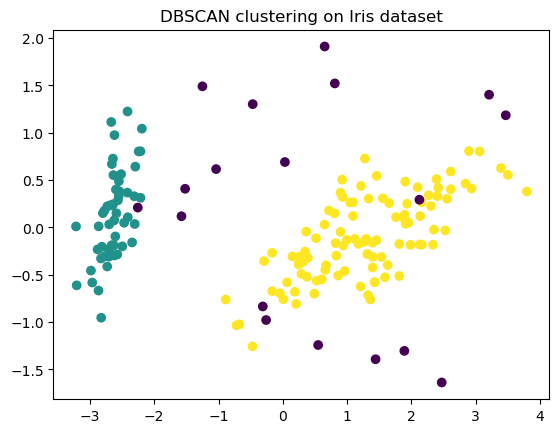

In [11]:
# dbscan on the 4D data
db = DBSCAN(eps=0.65) 
iris_pred = db.fit_predict(X)   

# Count predicted outliers
pred_outliers = (iris_pred == -1)
print("Predicted outliers:", pred_outliers.sum())

#visualize in the main plane of the ACP
fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=iris_pred)
plt.title("DBSCAN clustering on Iris dataset")
plt.show()

c:\Users\Ethel Ogallo\.conda\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


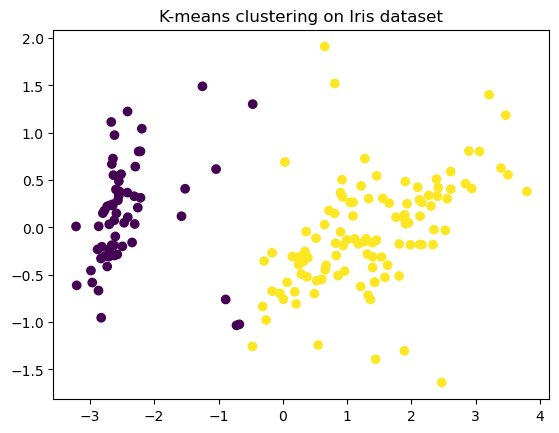

In [12]:
# kmeans on the 4D data
kmeans = KMeans(n_clusters=2, random_state=0)
iris_kmeans = kmeans.fit_predict(X)

#visualize in the main plane of the ACP
fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=iris_kmeans)
plt.title("K-means clustering on Iris dataset")
plt.show()

## Question

Using the functions in `sklearn.metrics`, calculate the rate of correct detection of outliers. Up to what proportion of noisy data is the partitioning obtained by DBSCAN robust?

In [13]:
# rate of correct detections of outliers 
from sklearn.metrics import precision_score, recall_score, f1_score

# True vs predicted outlier masks
true_outliers = (y == -1)
pred_outliers = (iris_pred == -1)

# Compute detection metrics
precision = precision_score(true_outliers, pred_outliers)
recall = recall_score(true_outliers, pred_outliers)
f1 = f1_score(true_outliers, pred_outliers)

print(f"precision: {precision:.2f}")
print(f"recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")



precision: 0.83
recall: 0.75
F1-score: 0.79


In [14]:
# Varying the amount of noise in the data
noise_fractions = [0.05, 0.1, 0.2, 0.3]

for frac in noise_fractions:
    n_noise = int(frac * 150) # number of synthetic noise points to add
    noise = np.random.rand(n_noise, 4) * (max_ - min_) + min_ 

    X = np.concatenate((X, noise), axis=0)
    y = np.concatenate((y, -1 * np.ones(n_noise, dtype=int)), axis=0)

    db = DBSCAN(eps=0.65)
    pred = db.fit_predict(X)

    true_outliers = (y == -1)
    pred_outliers = (pred == -1)

    f1 = f1_score(true_outliers, pred_outliers, zero_division=0)
    
    print(f"Noise: {frac:.0%} | F1: {f1:.2f}")


Noise: 5% | F1: 0.85
Noise: 10% | F1: 0.86
Noise: 20% | F1: 0.89
Noise: 30% | F1: 0.90


Up to what proportion of noisy data is the partitioning obtained by DBSCAN robust? ***around 20-30%***